In [10]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
import cv2
import itertools


def set_axis(x, no_labels = 10)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels


In [11]:
path_out = '20240507/'
files = glob.glob(path_out+"*")
files.sort()


In [12]:
dx= 5.106500953873407 
dt= 0.0016


data = []
first_filename = files[0]

# our dataset
# start = files.index('20240507\\092152.npy')
# end = files.index('20240507\\092342.npy')

# Thinner lines here
start = files.index('20240507\\092152.npy') + 10
end = files.index('20240507\\092342.npy') + 10
for file in files[start:end+1]:
   print(f'Loading file: {file}')
   data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime('2024-05-07 ' + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)
df_original = df.copy()

Loading file: 20240507\092332.npy
Loading file: 20240507\092342.npy
Loading file: 20240507\092352.npy
Loading file: 20240507\092402.npy
Loading file: 20240507\092412.npy
Loading file: 20240507\092422.npy
Loading file: 20240507\092432.npy
Loading file: 20240507\092442.npy
Loading file: 20240507\092452.npy
Loading file: 20240507\092502.npy
Loading file: 20240507\092512.npy
Loading file: 20240507\092522.npy


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_spectrogram(data, original_df=None, fs=(6,8), no_labels=7):
    if not isinstance(data, pd.DataFrame):
        if original_df is None:
            raise ValueError("If data is not a DataFrame, original_df must be provided for index/columns.")
        data = pd.DataFrame(data=np.abs(data), index=original_df.index, columns=original_df.columns)
    
    fig = plt.figure(figsize=fs)
    ax = plt.axes()

    data -= data.mean()
    data = np.abs(data)
    low, high = np.percentile(data, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    im = ax.imshow(data, interpolation='none', aspect='auto', norm=norm, origin='lower')

    # --- Labeling logic ---
    if isinstance(data.index, pd.DatetimeIndex):
        y_positions, y_labels = set_axis(data.index.time,no_labels)
        ax.set_ylabel("Time")
    else:
        y_positions, y_labels = set_axis(data.index.values,no_labels)
        if "freq" in str(data.index.name).lower():
            ax.set_ylabel("Frequency (Hz)")
        else:
            ax.set_ylabel("Time (s)")
    x_positions, x_labels = set_axis(data.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    ax.set_yticks(y_positions, y_labels)

    plt.xlabel("Channels / Spatial Position")
    cax = fig.add_axes([ax.get_position().x1+0.06, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)
    plt.show()

    
def visualize_df(df,fs=(4,8)):
    df = np.array(df)
    fig = plt.figure(figsize=fs)
    ax = plt.axes()
    arr = df.copy()
    arr = arr - arr.mean()
    arr = np.abs(arr)
    low, high = np.percentile(arr, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    im = ax.imshow(arr, interpolation='none', aspect='auto', norm=norm, origin='lower')

    plt.show()
    

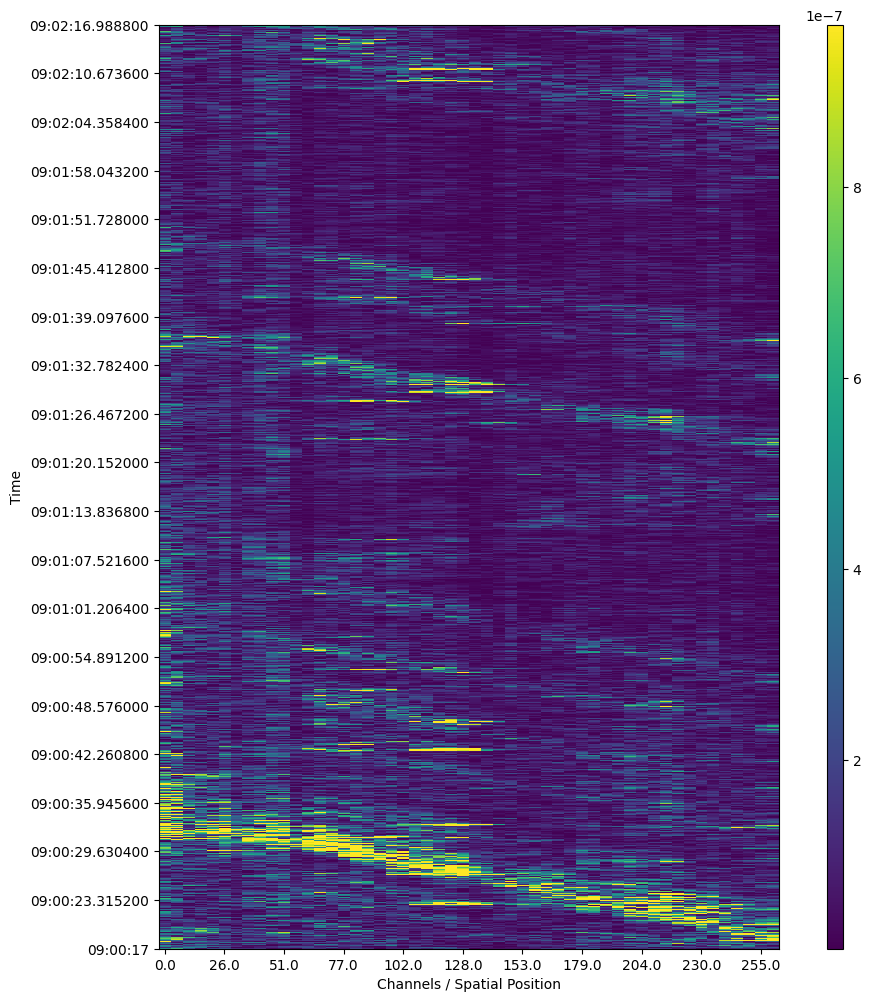

In [14]:
plot_spectrogram(df, fs=(8,12), no_labels=20)   

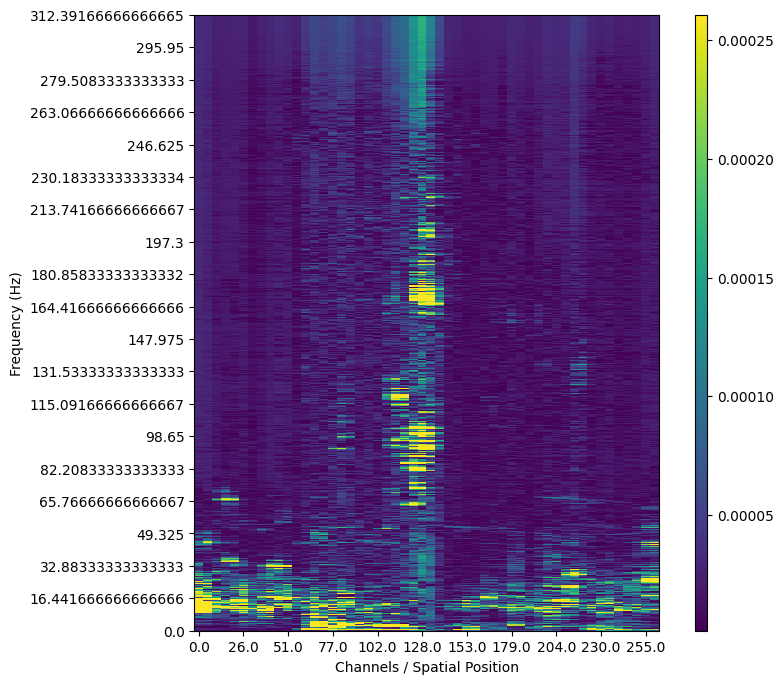

In [15]:
def fft_channels(df, dt):
    reverted = {}
    fft_results = {}

    n = len(df)

    # Only non-negative frequencies (0 ... Nyquist)
    freqs = np.fft.rfftfreq(n, d=dt)

    for channel in df.columns:
        signal = df[channel].values
        
        # Only positive-frequency FFT
        fft_result = np.fft.rfft(signal)

        # Magnitude spectrum
        fft_results[channel] = np.abs(fft_result)

        # Real-valued inverse FFT
        reverted[channel] = np.fft.irfft(fft_result, n=n)

    # Build time index
    if isinstance(df.index, pd.DatetimeIndex):
        time_index = (df.index - df.index[0]).total_seconds()
    else:
        time_index = np.arange(n) * dt

    # DataFrames
    reverted_df = pd.DataFrame(reverted, index=time_index)
    fft_df = pd.DataFrame(fft_results, index=freqs)

    reverted_df.index.name = "Time (s)"
    fft_df.index.name = "Frequency (Hz)"

    return reverted_df, fft_df

reverted_df, fft_df = fft_channels(df, dt)
plot_spectrogram(fft_df, fs=(6,8) ,no_labels=20)


(37501,)


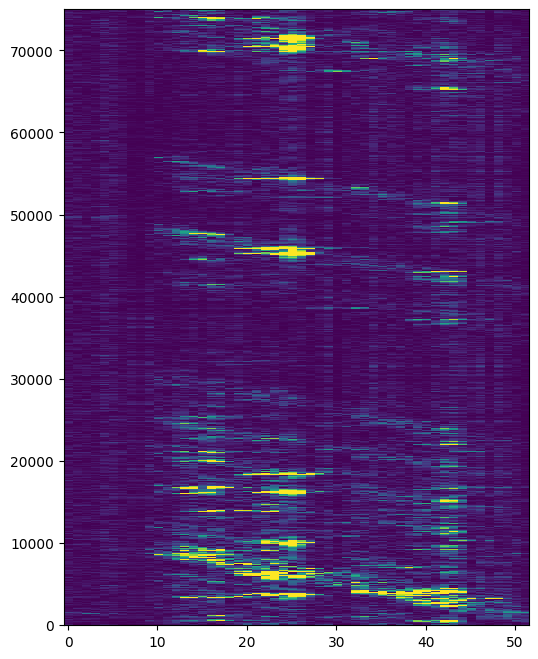

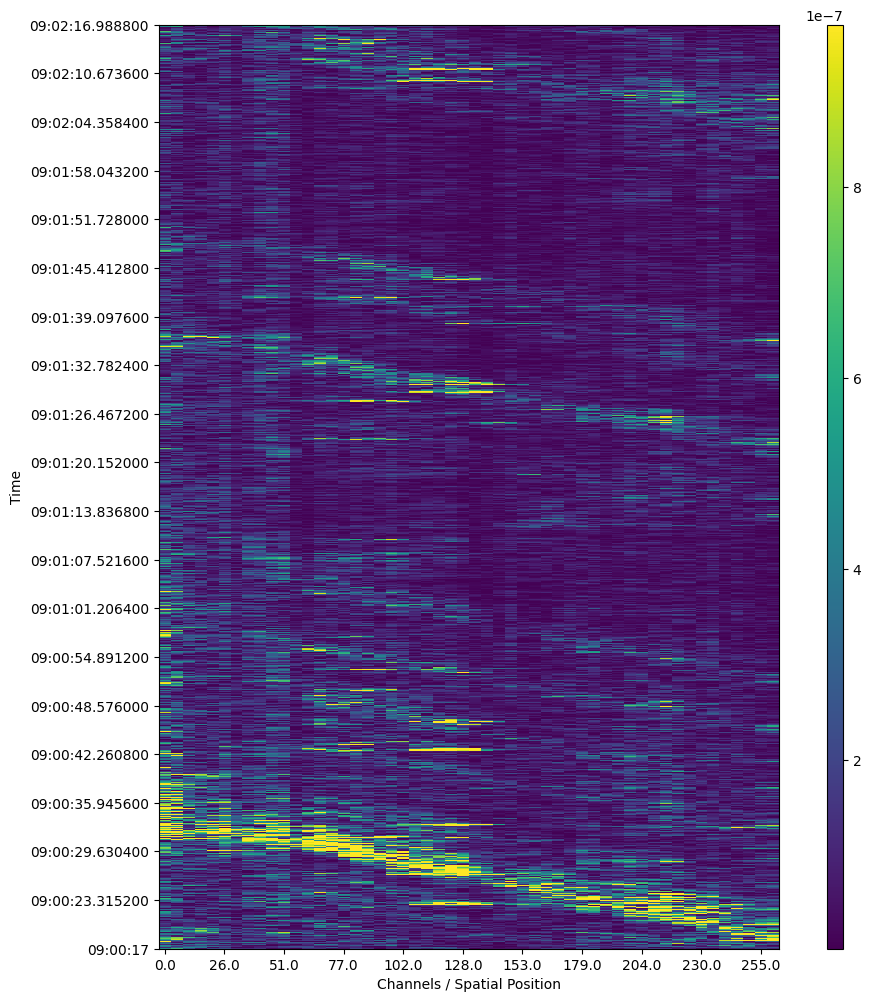

In [16]:
def fft_modify(df, dt,constraints):
    reverted = {}
    fft_results = {}

    n = len(df)

    # Frequency axis (>= 0 only)
    freqs = np.fft.rfftfreq(n, d=dt)
    print(freqs.shape)



    for channel in df.columns:
        signal = df[channel].values
        fft_result = np.fft.rfft(signal)

        remove_mask = np.ones_like(freqs, dtype=bool)
        for constraint in constraints:
            if(channel>=constraint[0] and channel<=constraint[1]):
                freq_range = constraints[constraint]
                remove_mask &= ~((freqs >= freq_range[0]) & (freqs <= freq_range[1]))
                break

        # Zero out unwanted frequencies
        fft_result[remove_mask] = 0

        # Magnitude spectrum
        fft_results[channel] = np.abs(fft_result)

        # Reconstruct time signal
        reverted[channel] = np.fft.irfft(fft_result, n=n)

    # Build time index
    if isinstance(df.index, pd.DatetimeIndex):
        time_index = (df.index - df.index[0]).total_seconds()
    else:
        time_index = np.arange(n) * dt

    # DataFrames
    reverted_df = pd.DataFrame(reverted, index=time_index)
    fft_df = pd.DataFrame(fft_results, index=freqs)

    reverted_df.index.name = "Time (s)"
    fft_df.index.name = "Frequency (Hz)"

    return reverted_df, fft_df

constraints ={ 
    (10*5.10, 20*5.11): (70,90),
    (20*5.10, 30*5.11): (90,110),
    (30*5.10, 50*5.11): (90,130),
    (0,3000): (110,120)
}

reverted_df, fft_df = fft_modify(df, dt, constraints)
visualize_df(np.concatenate([reverted_df], axis=1), fs=(6,8))
plot_spectrogram(df, fs=(8,12), no_labels=20)   

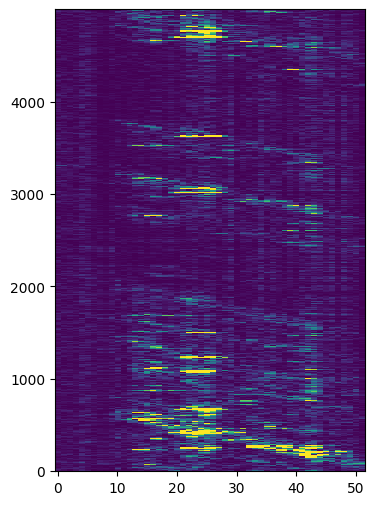

In [17]:
def bucket_vertically(df, buckets_no=500):
    bucketed_data = []
    num_rows = df.shape[0]
    bucketed_data = np.zeros((buckets_no, df.shape[1]))
    for i in range(buckets_no):
        start_row = int(i * num_rows / buckets_no)
        end_row = int((i + 1) * num_rows / buckets_no)
        bucketed_data[i, :] = df.iloc[start_row:end_row, :].mean(axis=0)
    blur = cv2.medianBlur(bucketed_data.astype(np.float32), 5)

    return np.array(bucketed_data)
    
visualize_df(bucket_vertically(reverted_df, buckets_no=5000), fs=(4,6))

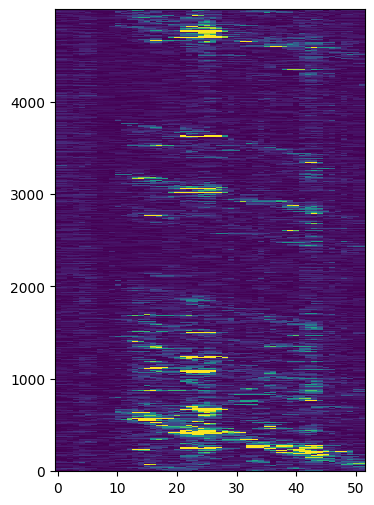

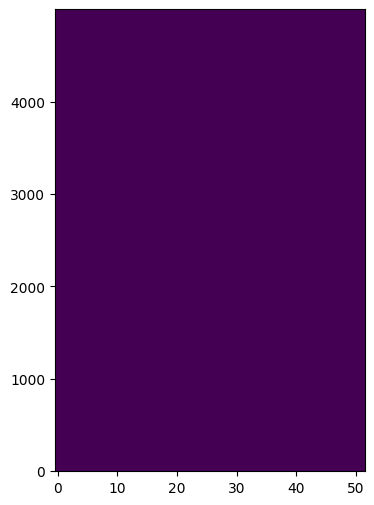

[array([ 14, 236,  41, 242], dtype=int32), array([ 21, 224,  43, 254], dtype=int32), array([  22, 1496,   44, 1464], dtype=int32)]


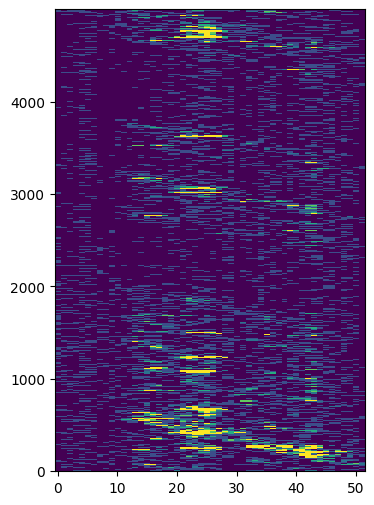

Clusters formed: 2


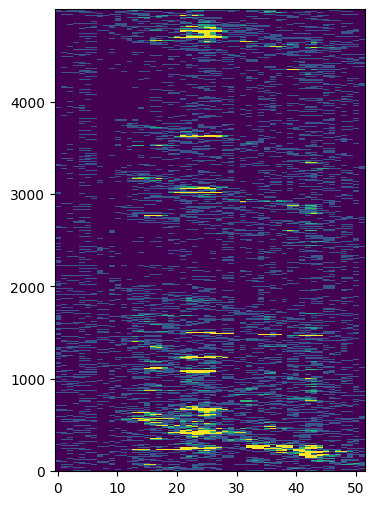

In [18]:
def filter_and_cluster_lines(lines, img):
    if lines is None:
        return []
    
    lines_horizontal = []
    for line in lines:
        slope = (line[0][3] - line[0][1]) / (line[0][2] - line[0][0] + 1e-6)
        horizontal_length = abs(line[0][2] - line[0][0])
        # print("Slope:", slope)
        if abs(slope)<2 and horizontal_length > 20:
            lines_horizontal.append(line[0])
            
            
    print(lines_horizontal)
    
    line_img = img.copy()
    for x1, y1, x2, y2 in lines_horizontal:
        cv2.line(line_img, (x1, y1), (x2, y2), color=1, thickness=1)
    visualize_df(line_img, fs=(4,6))
    
    slope_th = 10
    intercept_th = 20
    lines_preprocessed = []
    for x1, y1, x2, y2 in lines_horizontal:
        slope = (x2-x1) / (y2-y1) if (y2 - y1) != 0 else np.inf
        lines_preprocessed.append((slope, x1, y1, x2, y2))
        
    clusters = []
    for slope, x1, y1, x2, y2 in lines_preprocessed:
        f=False
        for cluster in clusters:
            for line2 in cluster:
                if abs(line2[0] - slope) < slope_th and abs((y1+y2)/2 - (line2[2]+line2[4])/2) < intercept_th:
                    cluster.append((slope, x1, y1, x2, y2))
                    f=True
                    break
            if f:
                break
        if not f:
            clusters.append([(slope, x1, y1, x2, y2)])
        
             
    clusters_lines = []
    for cluster in clusters:
        x1_avg = int(np.mean([line[1] for line in cluster]))
        y1_avg = int(np.mean([line[2] for line in cluster]))
        x2_avg = int(np.mean([line[3] for line in cluster]))
        y2_avg = int(np.mean([line[4] for line in cluster]))
        clusters_lines.append((x1_avg, y1_avg, x2_avg, y2_avg))

        
    print("Clusters formed:", len(clusters_lines))
    line_img = img.copy()
    for x1, y1, x2, y2 in clusters_lines:
        cv2.line(line_img, (x1, y1), (x2, y2), color=1, thickness=2)
    visualize_df(line_img, fs=(4,6))
    return clusters_lines
    

def canny_edge_detection(df):
    lower = 10
    upper = 20
    df_gray = cv2.normalize(df, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    edges = cv2.Canny(df_gray, lower, upper)
    return edges

bucketed_df = bucket_vertically(reverted_df, buckets_no=5000)
kernel = np.ones((1,3), np.uint8)  # tall and narrow
closing = cv2.morphologyEx(bucketed_df, cv2.MORPH_CLOSE, kernel)
visualize_df(closing, fs=(4,6))

edges = canny_edge_detection(closing)
edges = cv2.dilate(edges, np.ones((1,1), np.uint8), iterations=1)
edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
visualize_df(edges, fs=(4,6))
#0, 500, 50
# Iterate over all combinations
lines = cv2.HoughLinesP(edges, rho=2, theta=np.pi/180,
                        threshold=0,
                        minLineLength=0,
                        maxLineGap=30)

line_img = cv2.normalize(bucketed_df.copy(), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)   
lines2 = filter_and_cluster_lines(lines, line_img)